In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jf_wep.donutStamp import DonutStamp
from jf_wep.utils.imageMapper import ImageMapper
from jf_wep.utils.enums import DefocalType
from jf_wep.wfAlgorithms.tie import TIEAlgorithm
from scipy.ndimage import gaussian_filter


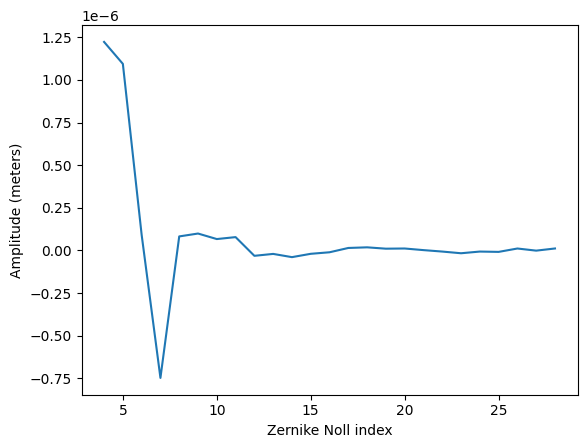

In [2]:
# Set some random Zernikes
rng = np.random.default_rng(1243)
zk = rng.normal(0, 5e-6 / np.arange(1, 26) ** 2, size=25)

fig, ax = plt.subplots()
ax.plot(np.arange(4, 29), zk)
ax.set(xlabel="Zernike Noll index", ylabel="Amplitude (meters)")
plt.show()


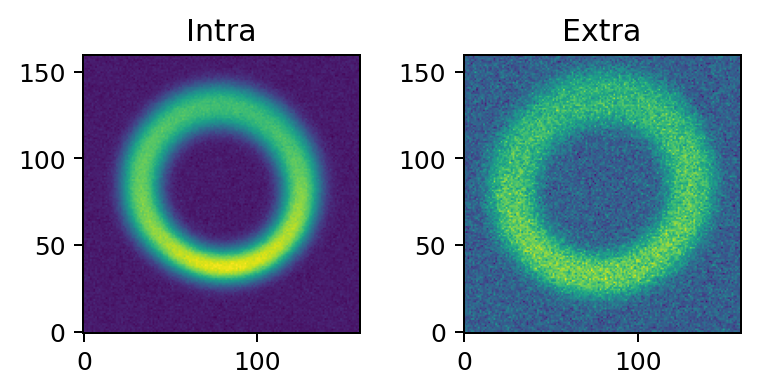

In [3]:
# Forward model a pair of donuts

mapper = ImageMapper(opticalModel="offAxis")

intraImg = mapper.pupilToImage(
    DonutStamp(
        320 * mapper.instrument.createPupilMask(160).astype(float),
        (0, 0),
        "intra",
        "r",
    ),
    zk,
)
intraImg.config(
    image=gaussian_filter(intraImg.image, 5)
    + rng.normal(scale=10, size=intraImg.image.shape)
)

extraImg = mapper.pupilToImage(
    DonutStamp(
        gaussian_filter(100 * mapper.instrument.createPupilMask(160), 1),
        (0, 0),
        "extra",
        "r",
    ),
    zk,
)
extraImg.config(
    image=gaussian_filter(extraImg.image, 5)
    + rng.normal(scale=15, size=extraImg.image.shape)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), dpi=180)

ax1.imshow(intraImg.image, origin="lower")
ax1.set(title="Intra")

ax2.imshow(extraImg.image, origin="lower")
ax2.set(title="Extra")

plt.show()

In [4]:
# Use the TIE to estimate Zernikes
algo = TIEAlgorithm(opticalModel="paraxial")
zkEst = algo.estimateWf(intraImg, extraImg)


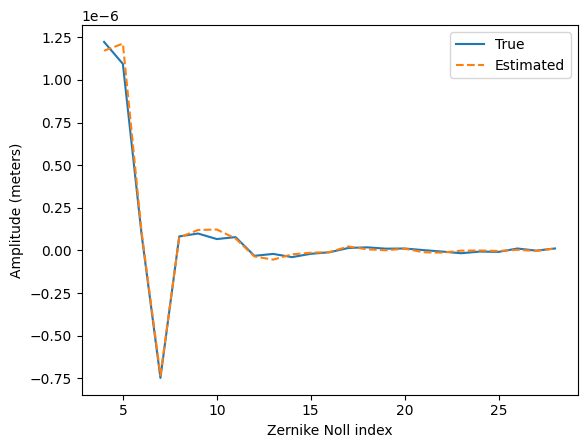

In [5]:
fig, ax = plt.subplots()

ax.plot(4 + np.arange(len(zk)), zk, label="True")
ax.plot(4 + np.arange(len(zkEst)), zkEst, label="Estimated", ls="--")
ax.legend()

ax.set(xlabel="Zernike Noll index", ylabel="Amplitude (meters)")
plt.show()

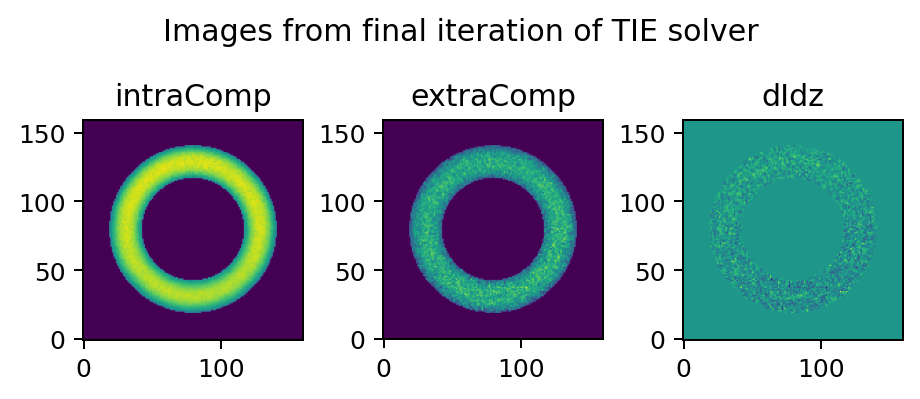

In [6]:
# Plot images from the final iteration of the TIE solver
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(5, 2.2), dpi=180, constrained_layout=True
)

finalIter = max(algo.history.keys())

ax1.imshow(algo.history[finalIter]["intraComp"], origin="lower")
ax1.set(title="intraComp")

ax2.imshow(algo.history[finalIter]["extraComp"], origin="lower")
ax2.set(title="extraComp")

ax3.imshow(algo.history[finalIter]["dIdz"], origin="lower")
ax3.set(title="dIdz")

fig.suptitle("Images from final iteration of TIE solver")

plt.show()


We know we did well because `dIdz` mostly looks like noise.